<a href="https://colab.research.google.com/github/aditeyabaral/abstractive-summarization/blob/main/src/Summarize%20News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [111]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [112]:
import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

In [113]:
!curl -L -O https://raw.githubusercontent.com/aditeyabaral/abstractive-summarization/main/data/bbc_news.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7150k  100 7150k    0     0  11.2M      0 --:--:-- --:--:-- --:--:-- 11.2M


In [114]:
!curl -L -O https://raw.githubusercontent.com/aditeyabaral/abstractive-summarization/main/src/attention.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5230  100  5230    0     0  27967      0 --:--:-- --:--:-- --:--:-- 27967


In [115]:
import numpy as np
import pandas as pd
import re
import string
from google.colab import files
from gensim.models import FastText
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import attention
from attention import AttentionLayer

# Reading Dataset

In [136]:
df = pd.read_csv("bbc_news.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(2225, 2)


,TEXT,SUMMARY
0,Ad sales boost Time Warner profit\n\nQuarterly...,TimeWarner said fourth quarter sales rose 2% t...
1,Dollar gains on Greenspan speech\n\nThe dollar...,The dollar has hit its highest level against t...
2,Yukos unit buyer faces loan claim\n\nThe owner...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits\n\nBritish A...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq\n\nShares in...,Pernod has reduced the debt it took on to fund...


# Preprocessing Data

In [137]:
def formatArticleHeader(text):
  text = text.strip().split("\n\n")
  header = text[0] + ". "
  del text[0]
  #text[0] = header + text[0]
  text = "\n\n".join(text)
  return text

In [138]:
def cleanText(text):
  contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
  text = text.lower()
  text = re.sub(" +", " ", text)
  text = re.sub("\n+", " ", text)
  text = " ".join([contraction_mapping[w] if w in contraction_mapping else w for w in text.split()])
  return text

  # more preprocessing
  text = re.sub("[^a-zA-Z0-9\n]", " ", text)
  text = re.sub(r'\([^)]*\)', '', text)
  text = re.sub('"','', text)
  text = re.sub(r"'s\b","",text)
  return text 

In [139]:
df["TEXT"] = df["TEXT"].apply(lambda x: formatArticleHeader(x))
df["TEXT"] = df["TEXT"].apply(lambda x: cleanText(x))
df["SUMMARY"] = df["SUMMARY"].apply(lambda x: "<START> " + cleanText(x) + " <END>")

In [140]:
df.head()

,TEXT,SUMMARY
0,quarterly profits at us media giant timewarner...,<START> timewarner said fourth quarter sales r...
1,the dollar has hit its highest level against t...,<START> the dollar has hit its highest level a...
2,the owners of embattled russian oil giant yuko...,<START> yukos' owner menatep group says it wil...
3,british airways has blamed high fuel prices fo...,"<START> rod eddington, ba's chief executive, s..."
4,shares in uk drinks and food firm allied domec...,<START> pernod has reduced the debt it took on...


# Training fastText

In [141]:
X_words = list(map(word_tokenize, df["TEXT"].values))
y_words = list(map(word_tokenize, df["SUMMARY"].values))

In [142]:
"""ft_model = FastText(min_count=1)
ft_model.build_vocab(sentences=X_words+y_words)
ft_model.train(sentences=X_words+y_words, total_examples=ft_model.corpus_count, epochs=10)"""

'ft_model = FastText(min_count=1)\nft_model.build_vocab(sentences=X_words+y_words)\nft_model.train(sentences=X_words+y_words, total_examples=ft_model.corpus_count, epochs=10)'

In [143]:
#word2embedding = {word:ft_model.wv.get_vector(word) for word in list(ft_model.wv.vocab)}

# Finding Sequence Parameters

In [144]:
X_text = df["TEXT"].values
y_text = df["SUMMARY"].values

In [145]:
Tx = len(max(X_words, key=len))
Ty = len(max(y_words, key=len))
print(f"Tx = {Tx}\nTy = {Ty}")

Tx = 4960
Ty = 2230


In [146]:
tokenizer_X = Tokenizer()
tokenizer_X.fit_on_texts(list(X_text))
X_seq = tokenizer_X.texts_to_sequences(X_text)
X_seq = pad_sequences(X_seq,  maxlen=Tx, padding='post') 
vocab_size_X = len(tokenizer_X.word_index) + 1 

tokenizer_y = Tokenizer()
tokenizer_y.fit_on_texts(list(y_text))
y_seq = tokenizer_y.texts_to_sequences(y_text)
y_seq = pad_sequences(y_seq,  maxlen=Ty, padding='post') 
vocab_size_y = len(tokenizer_y.word_index) + 1 

print(f"Vocabulary Size of X = {vocab_size_X}\nVocabulary Size of y = {vocab_size_y}")

Vocabulary Size of X = 31828
Vocabulary Size of y = 21816


In [147]:
X_seq.shape, y_seq.shape

((2225, 4960), (2225, 2230))

# Creating Sequences

In [148]:
'''
K = int(0.6*df.shape[0])
X = X_seq[:K]
y = y_seq[:K]'''

'\nK = int(0.6*df.shape[0])\nX = X_seq[:K]\ny = y_seq[:K]'

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2002, 4960), (223, 4960), (2002, 2230), (223, 2230))

# Building Model

In [156]:
def createModel(X, y, Tx, Ty, X_vocab_size, y_vocab_size, dim=512):
  #encoder
  encoder_input = Input(shape=(Tx, ))
    
  enc_embedding =  Embedding(X_vocab_size, 100, trainable=True)(encoder_input)

  encoder_LSTM_1 = LSTM(dim, return_state=True, return_sequences=True)
  encoder_out_1, hidden_state_1, cell_state_1 = encoder_LSTM_1(enc_embedding)

  encoder_LSTM_2 = LSTM(dim, return_state=True, return_sequences=True)
  encoder_out_2, hidden_state_2, cell_state_2 = encoder_LSTM_2(encoder_out_1)

  encoder_LSTM_3 = LSTM(dim, return_state=True, return_sequences=True)
  encoder_out_3, hidden_state_3, cell_state_3 = encoder_LSTM_3(encoder_out_2)

  encoder_states = [hidden_state_3, cell_state_3]

  #decoder
  decoder_input = Input(shape=(None, ))
    
  dec_emb_layer = Embedding(y_vocab_size, 100, trainable=True)
  dec_emb = dec_emb_layer(decoder_input)

  decoder_LSTM_1 = LSTM(dim, return_state=True, return_sequences=True)
  decoder_out_1, _, _ = decoder_LSTM_1(dec_emb, initial_state=encoder_states)

  #decoder_LSTM_2 = LSTM(64, return_state=True)
  #decoder_out_2, _, _ = decoder_LSTM_2(decoder_out_1)

  attention_layer = AttentionLayer()
  attention_output, attention_states = attention_layer([encoder_out_3, decoder_out_1])

  decoder_concat = Concatenate(axis=-1)([decoder_out_1, attention_output])

  decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
  decoder_output = decoder_dense(decoder_concat)

  model = Model([encoder_input, decoder_input], decoder_output)
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model, encoder_input, encoder_states, decoder_input, decoder_LSTM_1, decoder_dense

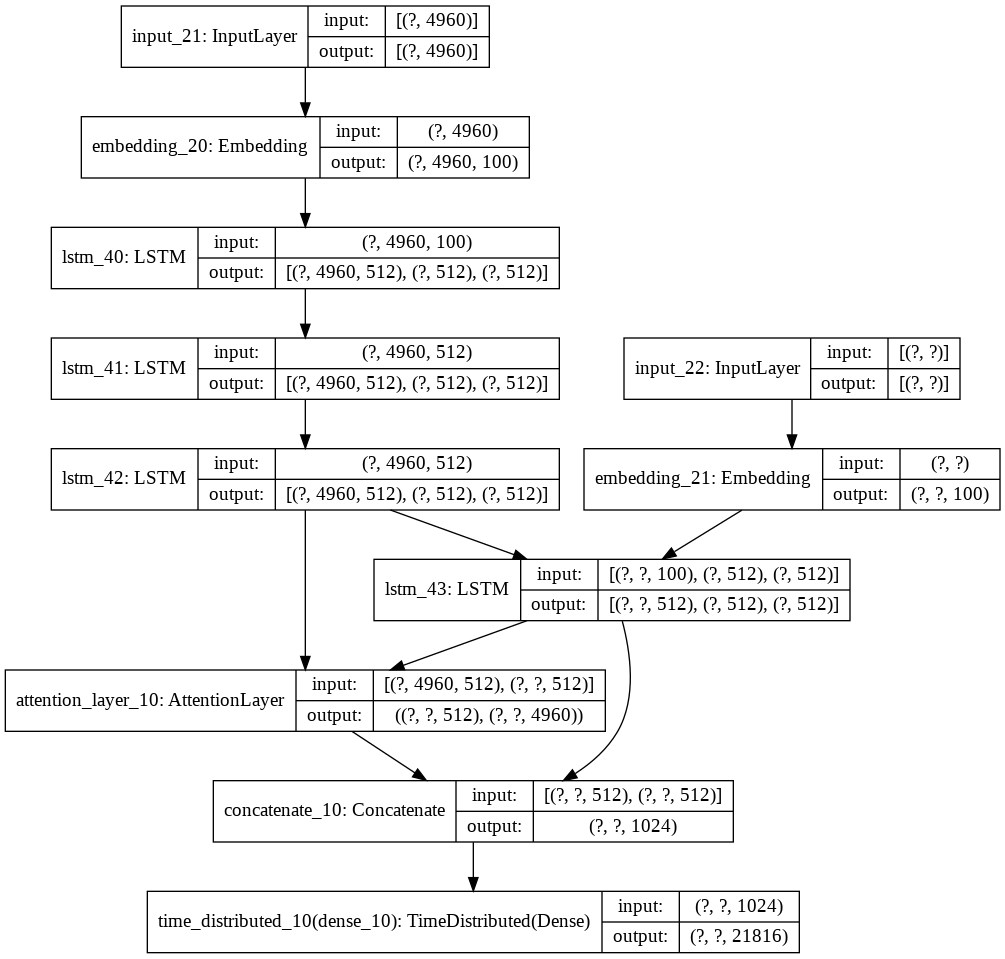

In [157]:
model, encoder_input, encoder_states, decoder_input, decoder_LSTM, decoder_dense = createModel(X_train, y_train, Tx, Ty, vocab_size_X, vocab_size_y, 512)
plot_model(model, show_shapes=True)

In [159]:
history = model.fit(
    [X_train,y_train[:,:-1]], 
    y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:],
    epochs=50,
    batch_size=128, 
    )

Epoch 1/50


CancelledError: ignored

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
pltt.show()

In [ ]:
model.save("news_model.h5")
files.download("news_model.h5")